## BME i9400
## Fall 2024
### Homework 3: Receiver Operating Characteristic (ROC) and Precision-Recall Curves


**Due date: Wednesday, October 30th 2024, 11:59:59.998 PM EST**

**Objective**: We have seen in class that accuracy is not always an appropriate measure of classifier accuracy (e.g. when the prevalence of one class is close to 1). In this case, we must use an alternative measure of performance. The most common performance metrics in binary classification are:
- [**Receiver Operating Characteristic (ROC) Curve**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
- [**Precision-Recall Curve**](https://en.wikipedia.org/wiki/Precision_and_recall)

To be able to compute these, we must first clarify the idea of a *threshold*. In binary classification, a threshold is a value that separates the positive and negative classes. If the predicted probability of the positive class is greater than the threshold, the sample is classified as positive; otherwise, it is classified as negative. 


We must also define the following terms:
- **True Positive Rate (TPR)**: The number of examples correctly predicted as positive divided by the total number of actual positive samples.
- **True Negative Rate (TNR)**: The number of examples correctly predicted as negative divided by the total number of actual negative samples.
- **False Positive Rate (FPR)**: The number of examples incorrectly predicted as positive divided by the total number of actual negative samples.
- **False Negative Rate (FNR)**: The number of examples incorrectly predicted as negative divided by the total number of actual positive samples.

- **Precision**: The number of examples correctly predicted as positive divided by the total number of predicted positive samples.
- **Recall**: The number of examples correctly predicted as positive divided by the total number of actual positive samples. Note that this is equivalent to the TPR.


To construct an ROC curve, we vary the threshold from 0 to 1 and compute the TPR and FPR at each threshold. The ROC curve is a plot of TPR vs. FPR. The area under the ROC curve (AUC) provides an overall measure of the classifier's performance. AUC ranges from 0 to 1, where 1 indicates a perfect classifier and 0.5 is "chance" performance (random guessing).

To construct a precision-recall curve, we vary the threshold from 0 to 1 and compute the precision and recall at each threshold. The precision-recall curve is a plot of precision vs. recall. The average precision is the area under the precision-recall curve. Note that chance performance corresponds to an area given by the prevalence of the positive class -- not necessarily 0.5! 


In this assignment, you will compute these curves from scratch to evaluate the performance of a logistic regression classifier. You will then compare your answers to those obtained using the scikit-learn library. For this homework, we will work with a publicly available [dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) on stroke prediction, where the features characterize the health status of individuals and the target is whether or not they have had a stroke.

In the cells below, I have indicated places where code needs to be added with instructions contained in double hashtags (for example ## DO SOMETHING ##). 


In [1]:
## THIS CELL IS DONE FOR YOU

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load the data
health_data=pd.read_csv('healthcare-dataset-stroke-data.csv') # csv file must be in the same directory as the notebook

# We need to perform some preprocessing to remove missing values and encode categorical variables
impute= SimpleImputer(missing_values=np.nan, strategy='median')
health_data['bmi']=pd.DataFrame(impute.fit_transform(np.array(health_data['bmi']).reshape(-1, 1)))
OH=OneHotEncoder()
for col in health_data.select_dtypes(include=['object']):
  health_data[col]=OH.fit_transform(health_data[[col]]).toarray()

# Separate the features and the target
X = health_data.drop('stroke', axis=1).values  # features
y = health_data['stroke'].values # targets

# Scale the features to have zero mean and unit variance -- this helps gradient descent converge faster
X = StandardScaler().fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Generate the predicted _probabilities_ on the test set
y_pred_probs = clf.predict_proba(X_test)[:, 1]  # probability of the positive class

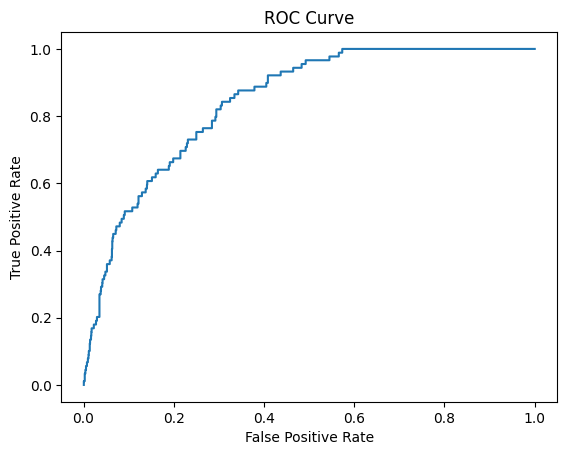

AUC: 0.8429456254474151


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_13769/2965299769.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


In [2]:
# ROC Curve construction and AUC calculation

# Function to compute TPR, FPR, TNR, FNR
def compute_rates(y_true, y_probs, threshold):
    """
    Compute tpr, fpr, tnr, and fnr for a single threshold value
    :param y_true: a vector of true labels (0 or 1)
    :param y_probs: a vector of predicted probabilities of the positive class
    :param threshold: a threshold value (scalar between 0 and 1)
    :return: a list whose elements are TPR, FPR, TNR, FNR
    """
    
    ## Compute the number of true positives, false positives, true negatives, and false negatives ##
    tpn = sum((y_probs >= threshold) & (y_true == 1))
    fpn = sum((y_probs >= threshold) & (y_true == 0))
    tnn = sum((y_probs < threshold) & (y_true == 0))
    fnn = sum((y_probs < threshold) & (y_true == 1))

    ## Compute the true positive rate (TPR), false positive rate (FPR), true negative rate (TNR), and false negative rate (FNR) ##
    tpr = tpn / sum(y_true == 1)
    fpr = fpn / sum(y_true == 0)
    tnr = tnn / sum(y_true == 0)
    fnr = fnn / sum(y_true == 1)

    ## return the list specified by the docstring ##
    return [tpr, fpr, tnr, fnr]

# Compute ROC Curve
def compute_roc_curve(y_true, y_probs):
    """
    Compute TPR and FPR for varying threshold values
    :param y_true: 
    :param y_probs: 
    :return: a typle of lists, where the first list contains the tpr values and the second list contains the fpr values
    """
    thresholds = np.sort(np.unique(y_probs))
    tpr_list, fpr_list = [], []
    
    ## Populate tpr_list and fpr_list here ##
    for threshold in thresholds:
        tprr, fprr, _, _ = compute_rates(y_true, y_probs, threshold)
        tpr_list.append(tprr)
        fpr_list.append(fprr)
    
    return tpr_list, fpr_list

## Call the compute_roc_curve function and store the results in tpr and fpr ##
tpr, fpr = compute_roc_curve(y_test, y_pred_probs)

## Plot ROC Curve ##
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
## Compute AUC using trapezoidal rule and print out the result ##

# Hint: you may have to sort the FPR values before computing the area under the curve
fpr, tpr = zip(*sorted(zip(fpr, tpr)))
auc = np.trapz(tpr, fpr)
print(f'AUC: {auc}')

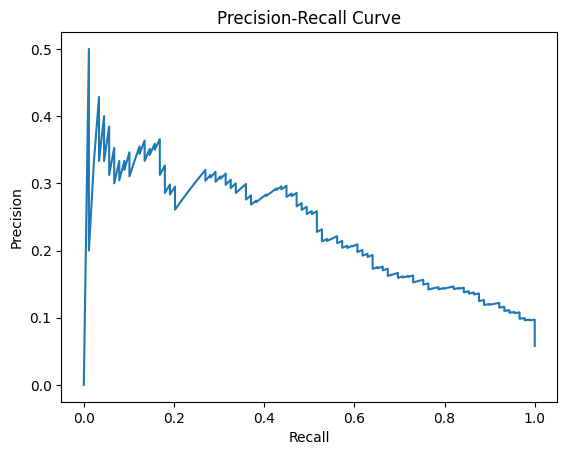

Average Precision: 0.23199343654895033


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_13769/1141223648.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(precision, recall)


In [3]:
# Precision Recall Curve construction and Average Precision calculation

def compute_pr(y_true, y_probs, threshold):
    """
    Compute precision and recall for a single threshold value
    :param y_true: vector of true labels (0 or 1)
    :param y_probs: vector of predicted probabilities of the positive class
    :param threshold: a threshold value (scalar between 0 and 1)
    :return: a tuple containing the precision and recall values in first and second positions, respectively
    """
    
    ## Compute precision ##
    tp = sum((y_probs >= threshold) & (y_true == 1))
    fp = sum((y_probs >= threshold) & (y_true == 0))
    precision = tp / (tp + fp)
    
    ## Compute recall ##
    recall = tp / sum(y_true == 1)
    
    
    return precision, recall

def compute_pr_curve(y_true, y_probs):
    """
    Compute precision and recall for varying threshold values
    :param y_true: vector of true labels (0 or 1)
    :param y_probs: vector of predicted probabilities of the positive class
    :return: a tuple of lists, where the first list contains the precision values and the second list contains the recall values
    """
    thresholds = np.sort(np.unique(y_probs))
    precision_list, recall_list = [], []

    ## populate precision_list and recall_list here ##
    for threshold in thresholds:
        prc, rcl = compute_pr(y_true, y_probs, threshold)
        precision_list.append(prc)
        recall_list.append(rcl)

    return precision_list, recall_list

## Call the compute_pr_curve function and store the results ##
precision, recall = compute_pr_curve(y_test, y_pred_probs)
## Plot Precision-Recall Curve ##
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
## Compute average precision and report the result ##
recall, precision = zip(*sorted(zip(recall, precision)))
ap = np.trapz(precision, recall)
print(f'Average Precision: {ap}')

In [4]:
# Compare your answers with the sklearn implementation

from sklearn.metrics import roc_auc_score, average_precision_score

## Call the roc_auc_score and average_precision_score functions from scikit-learn your data ##
roc_auc = roc_auc_score(y_test, y_pred_probs)
avg_precision = average_precision_score(y_test, y_pred_probs)

## Print out the results ##
print(f'AUC (sklearn): {roc_auc}')
print(f'Average Precision (sklearn): {avg_precision}')

AUC (sklearn): 0.8429456254474151
Average Precision (sklearn): 0.24013811340220162


AUC calculated using the trapezoidal rule and the scikit-learn implementation is the same. The average precision calculated using the trapezoidal rule and the scikit-learn differ slightly.